## We will build a model of the house prices in the state of California.
The data includes metrics such as:
* Population  
* Median income
* Median housing price per block group (a geographical unit)

The goal of the model is to predict the median housing price in any district given these metrics

### Framing the problem
The output (i.e. the prediction of a district's median housing price) will be fed to another ML system, which in turn will determine if it's worth investing in the area. 

Currently, the prices are estimated manually by experts. In addition to the costs the manual estimates are often upwards of 30% off.

#### Solution outline
The task is a supervised learning task, as there are labeled examples that can train the output. 
As we are asked to predict a _single_ value based on several parameters it is a univariate multiple regression problem. 

Finally, the data is fixed and a relatively small volume so it can be done in memory and without consideration of new data. 

In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import requests

def download_housing_data():
    '''
    Download dataset from Aurelien Gerons github. If the dataset exists it is not downloaded
    '''
    file_path = Path("datasets/housing.tgz")
    if not file_path.is_file():
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(file_path, 'wb') as writer:
                writer.write(response.raw.read())
        with tarfile.open(file_path) as housing_tar:
            housing_tar.extractall(path="datasets")
#download_housing_data()


In [3]:
# Load housing data
housing = pd.read_csv("datasets/housing/housing.csv")

In [4]:
# Read first couple of rows
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
# Descriptive statistics
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


<function matplotlib.pyplot.show(close=None, block=None)>

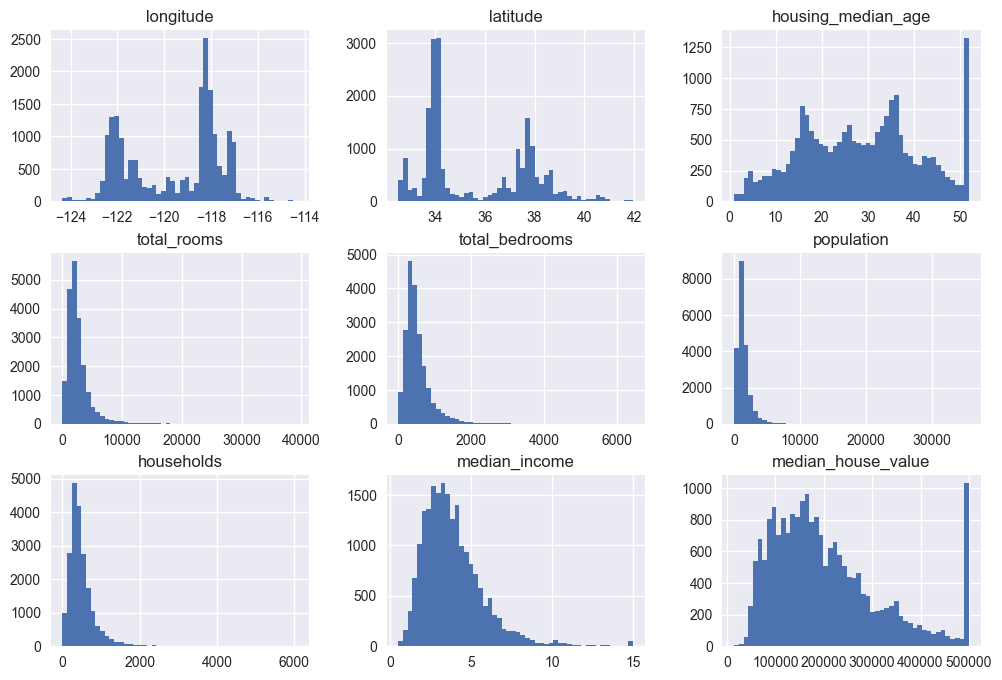

In [6]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

housing.hist(bins=50, figsize=(12,8))
plt.show

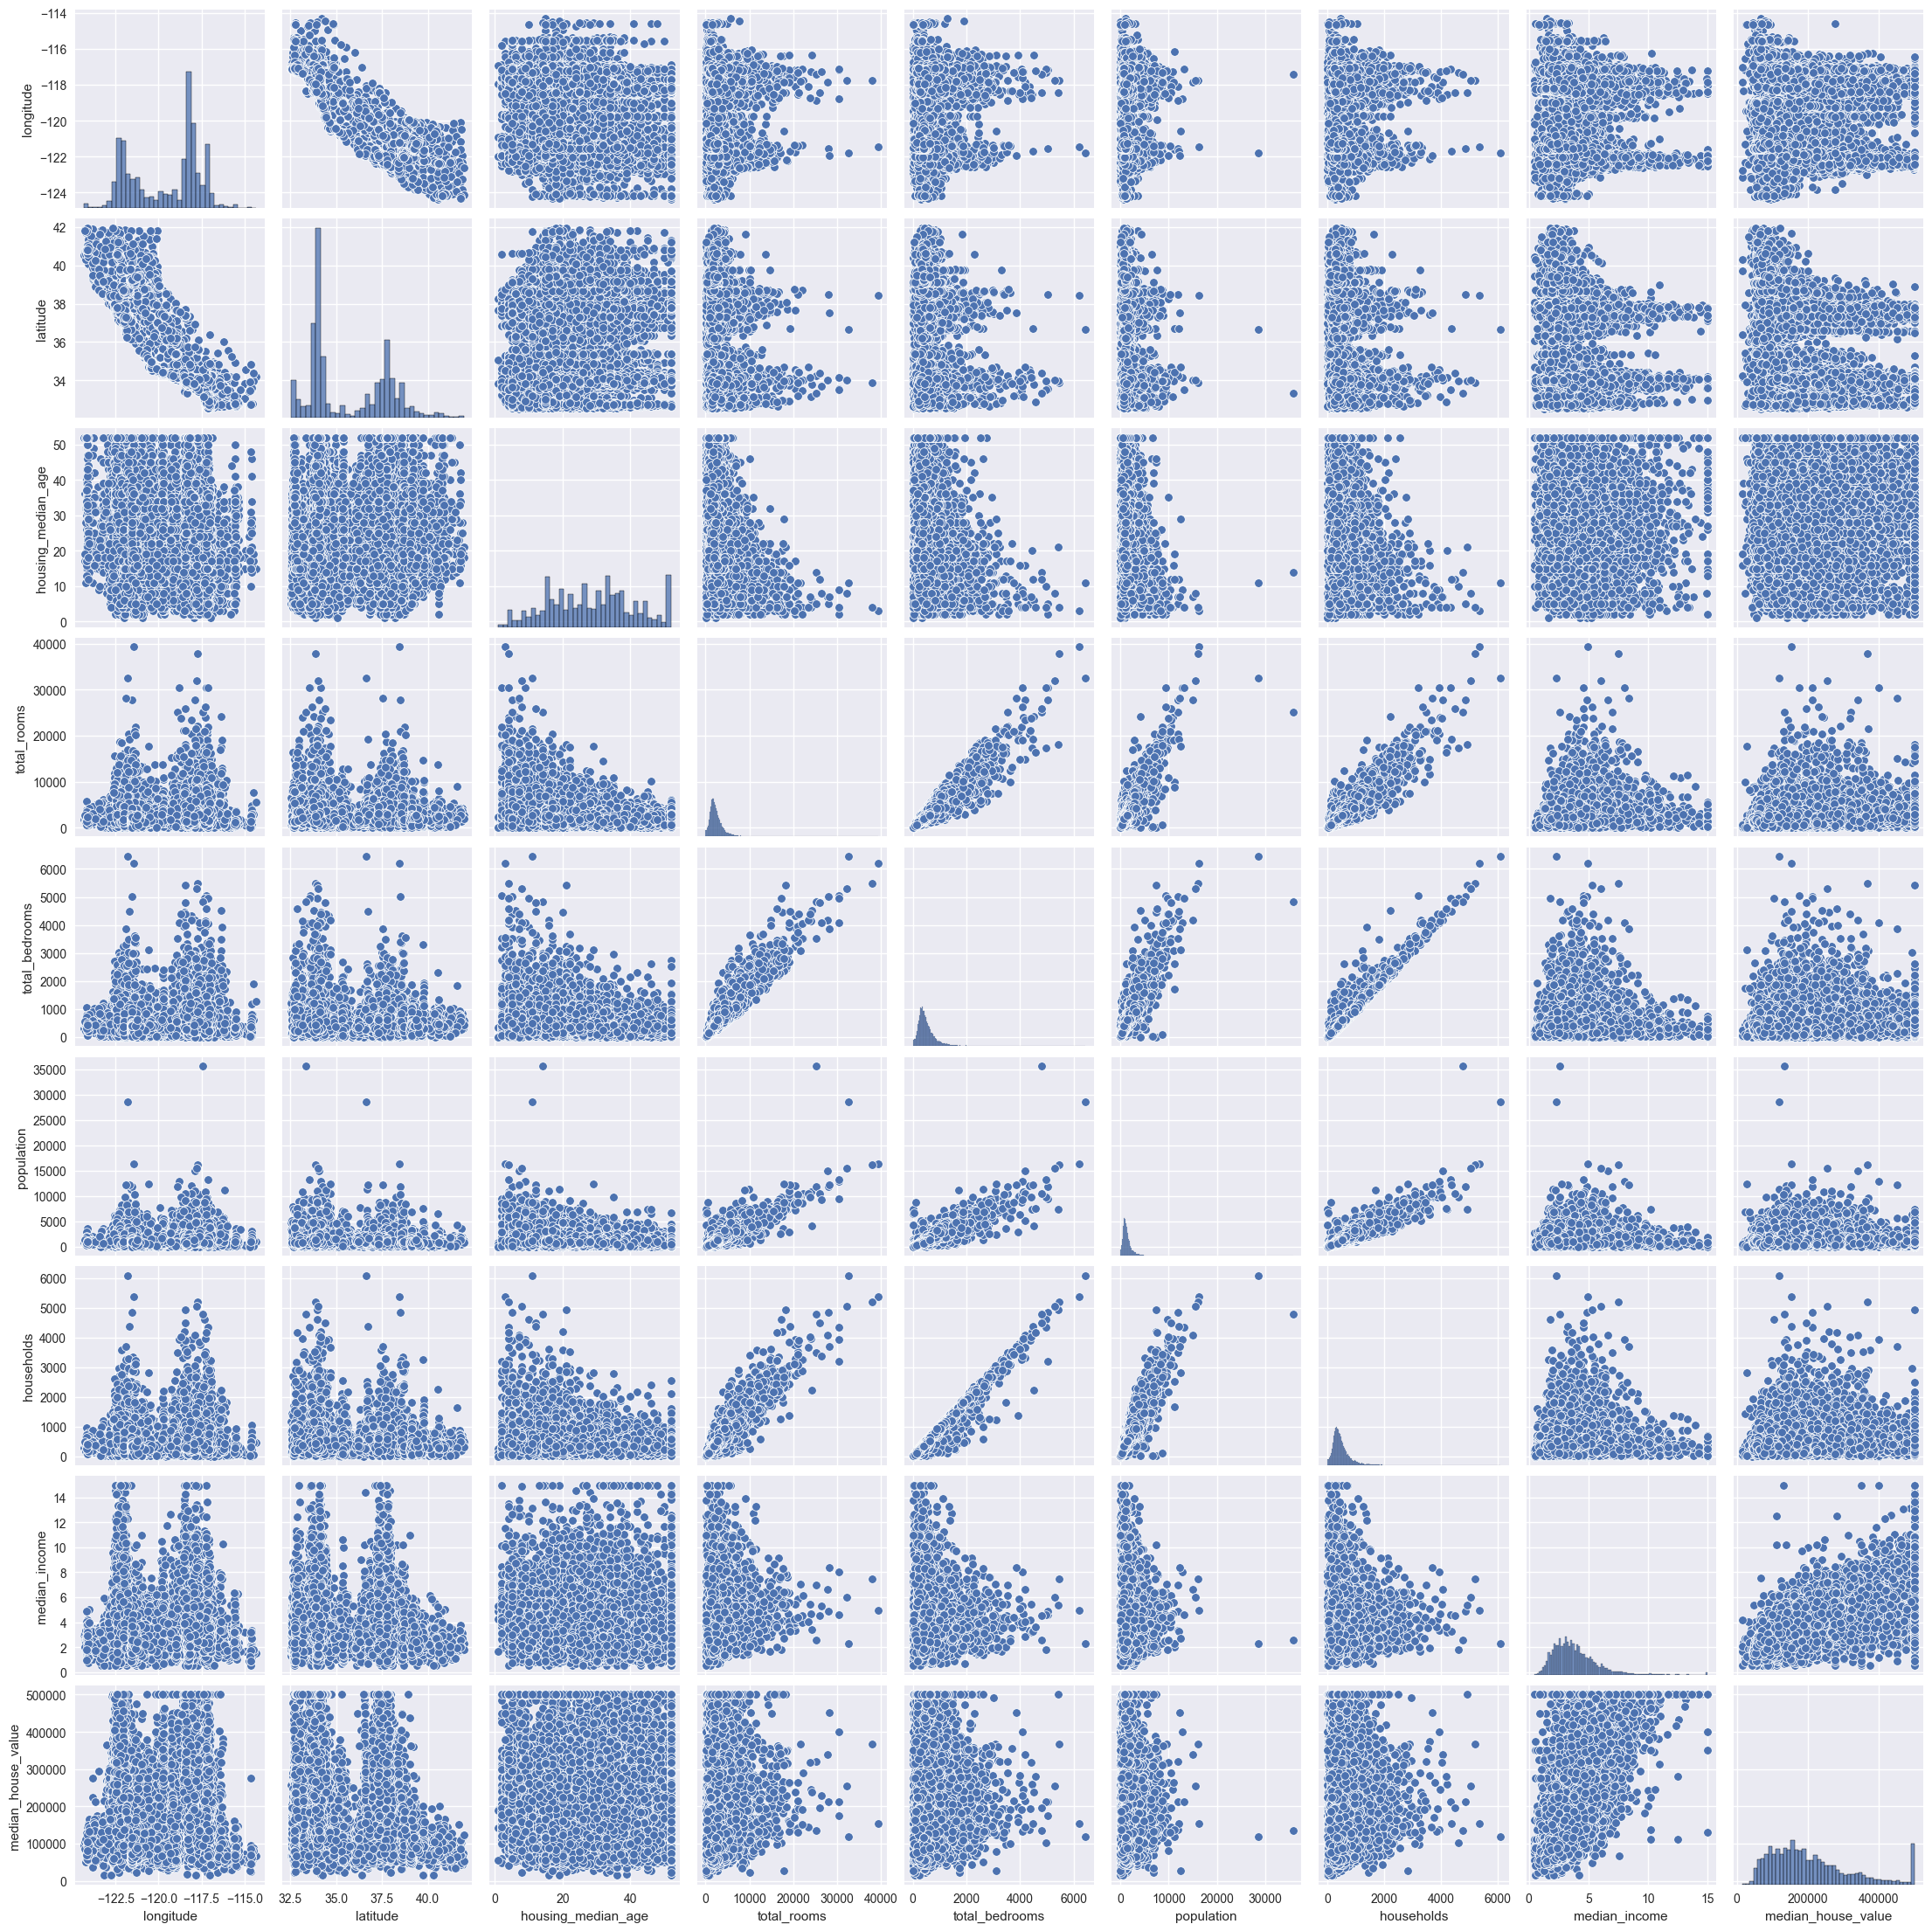

In [8]:
# Overkill
import seaborn as sns 
sns.pairplot(housing)

* Median income is not expressed in USD, but is given in tens of thousands of dollars.  
* Housing median age and median house values are capped which could / can cause problems.
* Datasets are skewed right - this can cause some ML algorithms to fail at detecting patterns.  

### Splitting test and training data
Basically scikit learn can be used to test data but here are some manual implementations to get the hang of it:

In [ ]:
# Create test set
import numpy as np

def shuffle_and_split_dat(data, test_ratio):
    '''
    This function will split data into a training dataset and a test dataset. 
    Every time the model runs (m) data will be regenerated, meaning the procedure slowly will go through the entire dataset.
    To avoid this np.random.seed(x) can be set, but this implementation will break the next time the dataset is updated.   
    '''
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)* test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size]
    return data.iloc[train_indices], data.iloc[test_indices]

### Keeping state between runs
Keeping consistency between runs can be ensured is to use each instances identifier to decide whether or not it should go into the test set.

In [9]:
from zlib import crc32

def is_id_in_test_set(identifier,test_ratio):
    '''
    
    '''
    return crc32(np.int64(identifier) < test_ratio * 2**32)

def split_data_with_id_hash(data, test_ratio, id_column):
    '''
    
    '''
    ids = data[id_column]
    in_test_set = ids.applit(lambda id_: is_id_in_test_set(id, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [ ]:
# Usage of the above
housing_with_id = housing.reset_index() 
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

### Sampling methods
The previously used sampling methods have been purely random - which is fine with large datasets. If it isn't you risk introducing sampling bias. 
It is important to ensure that the training data is representative. This can be done by using stratified sampling 